In [1]:
import os
import logging
import numpy as np
import netCDF4

import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

from datetime import datetime
from astropy.nddata import block_reduce

import torch
from torch import nn
from torch.cuda import get_device_name
from torch.optim.lr_scheduler import ExponentialLR
from torch.utils.data import DataLoader, RandomSampler
from torch.utils.data import Dataset

from tqdm import tqdm

from nf2.data.dataset import ImageDataset
from nf2.data.loader import _load_potential_field_data, RandomCoordinateSampler
from nf2.train.model import BModel, jacobian, VectorPotentialModel


In [2]:
class nlfff:

      def __init__(self,filename):
            self.filename=filename

            nc=netCDF4.Dataset(self.filename,'r')
            self.NOAA=nc.NOAA
            self.year_month_day_time=nc.year_month_day_time
            self.project=nc.project
            self.production_date=nc.production_date
            self.version=nc.version
            self.data_doi=nc.data_doi
            self.http_link=nc.http_link
            self.Distributor=nc.Distributor
            
            nc_x=nc.variables['x']
            self.x=nc_x[:]
            print(nc_x.long_name,' unit:',nc_x.units)
            nc_y=nc.variables['y']
            self.y=nc_y[:]
            print(nc_y.long_name,' unit:',nc_y.units)
            nc_z=nc.variables['z']
            self.z=nc_z[:]
            print(nc_z.long_name,' unit:',nc_z.units)
            
            nc_bx=nc.variables['Bx']
            self.bx=nc_bx[:].transpose(2,1,0)
            print(nc_bx.long_name,' unit:',nc_bx.units)
            nc_by=nc.variables['By']
            self.by=nc_by[:].transpose(2,1,0)
            print(nc_by.long_name,' unit:',nc_by.units)
            nc_bz=nc.variables['Bz']
            self.bz=nc_bz[:].transpose(2,1,0)
            print(nc_bz.long_name,' unit:',nc_bz.units)
            
            nc_bxp=nc.variables['Bx_pot']
            self.bx_pot=nc_bxp[:].transpose(2,1,0)
            print(nc_bxp.long_name,' unit:',nc_bxp.units)
            nc_byp=nc.variables['By_pot']
            self.by_pot=nc_byp[:].transpose(2,1,0)
            print(nc_byp.long_name,' unit:',nc_byp.units)
            nc_bzp=nc.variables['Bz_pot']
            self.bz_pot=nc_bzp[:].transpose(2,1,0)
            print(nc_bzp.long_name,' unit:',nc_bzp.units)
            
      def info(self):
            self.Lx_Mm=max(self.x) - min(self.x)
            self.Ly_Mm=max(self.y) - min(self.y)
            print(f'(Lx, Ly) in Mm = ({self.Lx_Mm:.2f}, {self.Ly_Mm:.2f})\n')
            print(f"NOAA",self.NOAA)
            print(f'year_month_day_time',self.year_month_day_time)
            print(f"project",self.project)
            print(f"production_date",self.production_date)
            print(f"version",self.version)
            print(f"data_doi",self.data_doi)
            print(f"http_link",self.http_link)
            print(f"Distributor",self.Distributor)

      def plot(self):
            xs=12.0
            ys=4.0

            xmin=min(self.x)
            xmax=max(self.x)
            ymin=min(self.y)
            ymax=max(self.y)

            plt.close()
            fig=plt.figure(figsize=(xs,ys))
            ax1=fig.add_axes((0.08,0.35,0.25,0.25*xs/ys*(ymax-ymin)/(xmax-xmin)))
            ax2=fig.add_axes((0.4,0.35,0.25,0.25*xs/ys*(ymax-ymin)/(xmax-xmin)))
            ax3=fig.add_axes((0.72,0.35,0.25,0.25*xs/ys*(ymax-ymin)/(xmax-xmin)))
            cax1=fig.add_axes((0.08,0.15,0.25,0.05))
            cax2=fig.add_axes((0.4,0.15,0.25,0.05))
            cax3=fig.add_axes((0.72,0.15,0.25,0.05))
            
            vmin=-3000.0 
            vmax=3000.0
            
            im1=ax1.pcolormesh(self.x,self.y,self.bx[:,:,0].transpose(),vmin=vmin,vmax=vmax,cmap='gist_gray',shading='auto')
            im2=ax2.pcolormesh(self.x,self.y,self.by[:,:,0].transpose(),vmin=vmin,vmax=vmax,cmap='gist_gray',shading='auto')
            im3=ax3.pcolormesh(self.x,self.y,self.bz[:,:,0].transpose(),vmin=vmin,vmax=vmax,cmap='gist_gray',shading='auto')

            cbar1=plt.colorbar(im1,cax=cax1,orientation='horizontal')
            cbar2=plt.colorbar(im2,cax=cax2,orientation='horizontal')
            cbar3=plt.colorbar(im3,cax=cax3,orientation='horizontal')
            
            ax1.set_title('Bx [G]')
            ax1.set_xlabel('x [Mm]')
            ax1.set_ylabel('y [Mm]')
            
            ax2.set_title('By [G]')
            ax2.set_xlabel('x [Mm]')
            ax2.set_ylabel('y [Mm]')
            
            ax3.set_title('Bz [G]')
            ax3.set_xlabel('x [Mm]')
            ax3.set_ylabel('y [Mm]')
            
            #plt.pause(0.1)
            # plt.savefig('./B.png')


In [3]:
# data = nlfff('/home/tensor/workspace/pinn_study/_data/12673_20170905_202400/12673_20170905_202400.nc')
data = nlfff('/nas/obsdata/isee_nlfff_v1.2/12673/12673_20170905_202400.nc')

x (westward)  unit: Mm
y (northward)  unit: Mm
z (out ot photosphere)  unit: Mm
Bx (westward)  unit: G
By (northward)  unit: G
Bz (out of photosphere)  unit: G
Bx_pot (westward)  unit: G
By_pot (northward)  unit: G
Bz_pot (out of photosphere)  unit: G


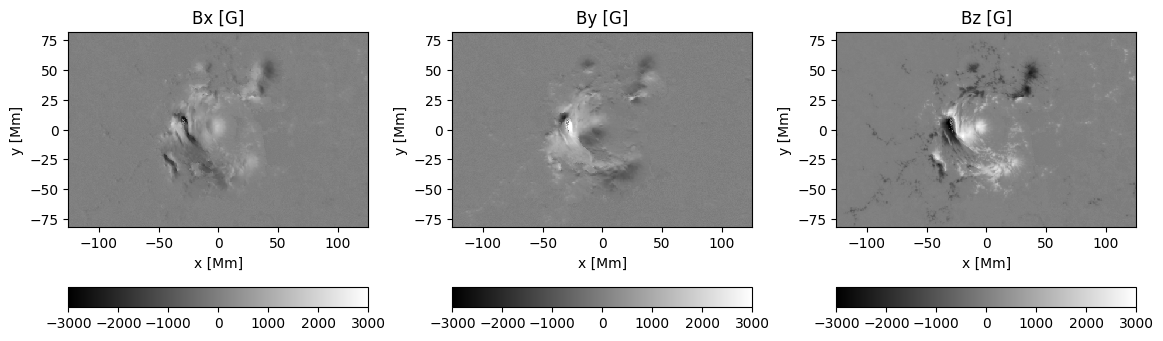

In [4]:
data.plot()

In [5]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]= "0"

# JSON
# base_path = '/home/tensor/workspace/pinn_study/_run/isee'
base_path = '/userhome/jeon_mg/workspace/pinn_study/_run/isee_bin1'
meta_path = None

# d_slice = None
bin = 1

height = 257
spatial_norm = 320
b_norm = 2500

meta_info = None
dim = 256
positional_encoding = False
use_potential_boundary = True
potential_strides = 4
use_vector_potential = False
lambda_div = 1e-1
lambda_ff = 1e-1
decay_iterations = 50000
device = None
work_directory = None

total_iterations = 100000
batch_size = 10000
log_interval = 10000
validation_interval = 10000
num_workers = 4

# init logging
os.makedirs(base_path, exist_ok=True)
log = logging.getLogger()
log.setLevel(logging.INFO)
for hdlr in log.handlers[:]:  # remove all old handlers
    log.removeHandler(hdlr)
log.addHandler(logging.FileHandler("{0}/{1}.log".format(base_path, "info_log")))  # set the new file handler
log.addHandler(logging.StreamHandler())  # set the new console handler

start_time = datetime.now()
base_path = os.path.join(base_path, 'dim%d_bin%d_pf%s_ld%s_lf%s' % (
        dim, bin, str(use_potential_boundary), lambda_div, lambda_ff))

b_cube = np.array(np.stack([data.bx[:, :, 0], data.by[:, :, 0], data.bz[:, :, 0]], axis=-1))
meta_info = None

# if d_slice is not None:
#     b_cube = b_cube[d_slice[0]:d_slice[1], d_slice[2]:d_slice[3]]

# if bin > 1:
#     b_cube = block_reduce(b_cube, (bin, bin, 1), np.mean)

TypeError: %d format: a number is required, not builtin_function_or_method

In [ ]:
class BoundaryDataset(Dataset):

    def __init__(self, batches_path):
        """Data set for lazy loading a pre-batched numpy data array.

        :param batches_path: path to the numpy array.
        """
        self.batches_path = batches_path

    def __len__(self):
        return np.load(self.batches_path, mmap_mode='r').shape[0]

    def __getitem__(self, idx):
        # lazy load data
        d = np.load(self.batches_path, mmap_mode='r')[idx]
        d = np.copy(d)
        coord, field= d[:, 0],  d[:, 1]
        return coord, field

def _plot_data(n_hmi_cube, plot_path, b_norm):
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(n_hmi_cube[..., 0].transpose(), vmin=-b_norm, vmax=b_norm, cmap='gray', origin='lower')
    axs[1].imshow(n_hmi_cube[..., 1].transpose(), vmin=-b_norm, vmax=b_norm, cmap='gray', origin='lower')
    axs[2].imshow(n_hmi_cube[..., 2].transpose(), vmin=-b_norm, vmax=b_norm, cmap='gray', origin='lower')
    plt.savefig(os.path.join(plot_path, 'b.jpg'))
    plt.close()

def prep_b_data(b_cube,
                height, spatial_norm, b_norm,
                potential_boundary=True, potential_strides=4,
                plot=False, plot_path=None):
    # load coordinates
    mf_coords = np.stack(np.mgrid[:b_cube.shape[0], :b_cube.shape[1], :1], -1)
    # flatten data
    mf_coords = mf_coords.reshape((-1, 3))
    mf_values = b_cube.reshape((-1, 3))
    # load potential field
    if potential_boundary:
        pf_coords, pf_err, pf_values = _load_potential_field_data(b_cube, height, potential_strides)
        # concatenate pf data points
        coords = np.concatenate([pf_coords, mf_coords])
        values = np.concatenate([pf_values, mf_values])
    else:
        coords = mf_coords
        values = mf_values

    coords = coords.astype(np.float32)
    values = values.astype(np.float32)

    # normalize data
    values = Normalize(-b_norm, b_norm, clip=False)(values) * 2 - 1

    # apply spatial normalization
    coords = coords / spatial_norm

    # stack to numpy array
    data = np.stack([coords, values], 1)

    if plot:
        _plot_data(b_cube, plot_path, b_norm)

    return data

class NF2Trainer:

    def __init__(self, base_path, b_cube, height, spatial_norm, b_norm, meta_info=None, dim=256,
                 positional_encoding=False, meta_path=None, use_potential_boundary=True, potential_strides=4, use_vector_potential=False,
                 lambda_div=0.1, lambda_ff=0.1, decay_iterations=None,
                 device=None, work_directory=None):
        """Magnetic field extrapolations trainer

        :param base_path: path to the results folder.
        :param b_cube: magnetic field data (x, y, (Bp, -Bt, Br)).
        :param height: height of simulation volume.
        :param spatial_norm: normalization of coordinate axis.
        :param b_norm: normalization of magnetic field strength.
        :param meta_info: additional data information. stored in the save state.
        :param dim: number of neurons per layer (8 layers).
        :param positional_encoding: use positional encoding.
        :param meta_path: start from a pre-learned simulation state.
        :param use_potential_boundary: use potential field as boundary condition. If None use an open boundary.
        :param potential_strides: use binned potential field boundary condition. Only applies if use_potential_boundary = True.
        :param use_vector_potential: derive the magnetic field from a vector potential.
        :param lambda_div: weighting parameter for divergence freeness of the simulation.
        :param lambda_ff: weighting parameter for force freeness of the simulation.
        :param decay_iterations: decay weighting for boundary condition (lambda_B=1000) over n iterations to 1.
        :param device: device for model training.
        :param work_directory: directory to store scratch data (prepared batches).
        """

        # general parameters
        self.base_path = base_path
        work_directory = base_path if work_directory is None else work_directory
        self.work_directory = work_directory
        self.save_path = os.path.join(base_path, 'extrapolation_result.nf2')
        self.checkpoint_path = os.path.join(base_path, 'checkpoint.pt')

        # data parameters
        self.spatial_norm = spatial_norm
        self.height = height
        self.b_norm = b_norm
        self.meta_info = meta_info

        # init directories
        os.makedirs(base_path, exist_ok=True)
        os.makedirs(work_directory, exist_ok=True)

        # init logging
        log = logging.getLogger()
        log.setLevel(logging.INFO)
        for hdlr in log.handlers[:]:  # remove all old handlers
            log.removeHandler(hdlr)
        log.addHandler(logging.FileHandler("{0}/{1}.log".format(base_path, "info_log")))  # set the new file handler
        log.addHandler(logging.StreamHandler())  # set the new console handler

        # log settings
        logging.info('Configuration:')
        logging.info(
            'dim: %d, lambda_div: %f, lambda_ff: %f, decay_iterations: %s, potential: %s, vector_potential: %s, ' % (
                dim, lambda_div, lambda_ff, str(decay_iterations), str(use_potential_boundary),
                str(use_vector_potential)))

        # setup device
        n_gpus = torch.cuda.device_count()
        device_names = [get_device_name(i) for i in range(n_gpus)]
        if device is None:
            device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
        logging.info('Using device: %s (gpus %d) %s' % (str(device), n_gpus, str(device_names)))
        self.device = device

        # prepare data
        self.b_cube = b_cube

        # load dataset
        self.data = prep_b_data(b_cube, height, spatial_norm, b_norm,
                                plot=True, plot_path=base_path,
                                potential_boundary=use_potential_boundary, potential_strides=potential_strides)
        self.cube_shape = [*b_cube.shape[:-1], height]

        # init model
        if use_vector_potential:
            model = VectorPotentialModel(3, dim, pos_encoding=positional_encoding)
        else:
            model = BModel(3, 3, dim, pos_encoding=positional_encoding)
        parallel_model = nn.DataParallel(model)
        parallel_model.to(device)
        opt = torch.optim.Adam(parallel_model.parameters(), lr=5e-4)
        self.model = model
        self.parallel_model = parallel_model

        # load last state
        if os.path.exists(self.checkpoint_path):
            state_dict = torch.load(self.checkpoint_path, map_location=device)
            start_iteration = state_dict['iteration']
            model.load_state_dict(state_dict['m'])
            opt.load_state_dict(state_dict['o'])
            history = state_dict['history']
            lambda_B = state_dict['lambda_B']
            logging.info('Resuming training from iteration %d' % start_iteration)
        else:
            if meta_path:
                state_dict = torch.load(meta_path, map_location=device)['model'].state_dict() \
                    if meta_path.endswith('nf2') else torch.load(meta_path, map_location=device)['m']
                model.load_state_dict(state_dict)
                opt = torch.optim.Adam(parallel_model.parameters(), lr=5e-5)
                logging.info('Loaded meta state: %s' % meta_path)
            # init
            start_iteration = 0
            lambda_B = 1000 if decay_iterations else 1
            history = {'iteration': [], 'height': [],
                       'b_loss': [], 'divergence_loss': [], 'force_loss': [], 'sigma_angle': []}

        self.opt = opt
        self.start_iteration = start_iteration
        self.history = history
        self.lambda_B = lambda_B
        self.lambda_B_decay = (1 / 1000) ** (1 / decay_iterations) if decay_iterations is not None else 1
        self.lambda_div, self.lambda_ff = lambda_div, lambda_ff

    def train(self, total_iterations, batch_size, log_interval=100, validation_interval=100, num_workers=None):
        """Start magnetic field extrapolation fit.

        :param total_iterations: number of iterations for training.
        :param batch_size: number of samples per iteration.
        :param log_interval: log training details every nth iteration.
        :param validation_interval: evaluate simulation every nth iteration.
        :param num_workers: number of workers for data loading (default system spec).
        :return: path of the final save state.
        """
        start_time = datetime.now()
        num_workers = os.cpu_count() if num_workers is None else num_workers

        model = self.parallel_model
        opt = self.opt
        history = self.history
        device = self.device
        lambda_div, lambda_ff = self.lambda_div, self.lambda_ff

        # init
        sampler = RandomCoordinateSampler(self.cube_shape, self.spatial_norm, batch_size * 2)
        scheduler = ExponentialLR(opt, gamma=(5e-5 / 5e-4) ** (1 / total_iterations))
        iterations = total_iterations - self.start_iteration
        if iterations <= 0:
            logging.info('Training already finished!')
            return self.save_path

        # init loader
        data_loader, batches_path = self._init_loader(batch_size, self.data, num_workers, iterations)

        total_b_diff = []
        total_divergence_loss = []
        total_force_loss = []
        model.train()
        for iter, (boundary_coords, b_true) in tqdm(enumerate(data_loader, start=self.start_iteration),
                                                           total=len(data_loader), desc='Training'):
            opt.zero_grad()
            # load input data
            boundary_coords, b_true= boundary_coords.to(device), b_true.to(device)
            random_coords = sampler.load_sample()

            # concatenate boundary and random points
            n_boundary_coords = boundary_coords.shape[0]
            coords = torch.cat([boundary_coords, random_coords], 0)
            coords.requires_grad = True

            # forward step
            b = model(coords)

            # compute boundary loss
            boundary_b = b[:n_boundary_coords]
            b_diff = torch.abs(boundary_b - b_true)
            b_diff = torch.mean(b_diff.pow(2).sum(-1))

            # compute div and ff loss
            divergence_loss, force_loss = calculate_loss(b, coords)

            # reset grad from auto-gradient operation
            opt.zero_grad()
            # compute loss
            (b_diff * self.lambda_B +
             divergence_loss.mean() * lambda_div +
             force_loss.mean() * lambda_ff).backward()
            # update step
            torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
            opt.step()

            # save loss information
            total_b_diff += [b_diff.detach().cpu().numpy()]
            total_divergence_loss += [divergence_loss.mean().detach().cpu().numpy()]
            total_force_loss += [force_loss.mean().detach().cpu().numpy()]

            # update training parameters
            if self.lambda_B > 1:
                self.lambda_B *= self.lambda_B_decay
            if scheduler.get_last_lr()[0] > 5e-5:
                scheduler.step()
            # logging
            if log_interval > 0 and (iter + 1) % log_interval == 0:
                # log loss
                logging.info('[Iteration %06d/%06d] [B-Field: %.08f; Div: %.08f; For: %.08f] [%s]' %
                             (iter + 1, iterations,
                              np.mean(total_b_diff),
                              np.mean(total_divergence_loss),
                              np.mean(total_force_loss),
                              datetime.now() - start_time))
                # reset
                total_b_diff = []
                total_divergence_loss = []
                total_force_loss = []

                # plot sample
                model.eval()
                self.plot_sample(iter, batch_size=batch_size)
                model.train()

                # log decay parameters
                logging.info('Lambda B: %f' % (self.lambda_B))
                logging.info('LR: %f' % (scheduler.get_last_lr()[0]))
            # validation
            if validation_interval > 0 and (iter + 1) % validation_interval == 0:
                model.eval()
                self.save(iter)
                # validate and plot
                mean_b, total_divergence, mean_force, sigma_angle = self.validate(self.height, batch_size)
                logging.info('Validation [Cube: B: %.03f; Div: %.03f; For: %.03f; Sig: %.03f]' %
                             (mean_b, total_divergence, mean_force, sigma_angle))
                #
                history['iteration'].append(iter + 1)
                history['b_loss'].append(mean_b.mean())
                history['divergence_loss'].append(total_divergence)
                history['force_loss'].append(mean_force)
                history['sigma_angle'].append(sigma_angle)
                self.plotHistory()
                #
                model.train()
        # save final model state
        torch.save({'m': self.model.state_dict(),
                    'o': self.opt.state_dict(), },
                   os.path.join(self.base_path, 'final.pt'))
        torch.save({'model': self.model,
                    'cube_shape': self.cube_shape,
                    'b_norm': self.b_norm,
                    'spatial_norm': self.spatial_norm,
                    'meta_info': self.meta_info}, self.save_path)
        # cleanup
        os.remove(batches_path)

        return self.save_path

    def _init_loader(self, batch_size, data, num_workers, iterations):
        # shuffle data
        r = np.random.permutation(data.shape[0])
        data = data[r]
        # adjust to batch size
        pad = batch_size - data.shape[0] % batch_size
        data = np.concatenate([data, data[:pad]])
        # split data into batches
        n_batches = data.shape[0] // batch_size
        batches = np.array(np.split(data, n_batches), dtype=np.float32)
        # store batches to disk
        batches_path = os.path.join(self.work_directory, 'batches.npy')
        np.save(batches_path, batches)
        # create data loaders
        dataset = BoundaryDataset(batches_path)
        # create loader
        data_loader = DataLoader(dataset, batch_size=None, num_workers=num_workers, pin_memory=True,
                                 sampler=RandomSampler(dataset, replacement=True, num_samples=iterations))
        return data_loader, batches_path

    def save(self, iteration):
        torch.save({'model': self.model,
                    'cube_shape': self.cube_shape,
                    'b_norm': self.b_norm,
                    'spatial_norm': self.spatial_norm,
                    'meta_info': self.meta_info}, self.save_path)
        torch.save({'iteration': iteration + 1,
                    'm': self.model.state_dict(),
                    'o': self.opt.state_dict(),
                    'history': self.history,
                    'lambda_B': self.lambda_B},
                   self.checkpoint_path)

    def plot_sample(self, iteration, n_samples=10, batch_size=4096):
        fig, axs = plt.subplots(3, n_samples, figsize=(n_samples * 4, 12))
        heights = np.linspace(0, 1, n_samples) ** 2 * (self.height - 1)  # more samples from lower heights
        imgs = np.array([self.get_image(h, batch_size) for h in heights])
        for i in range(3):
            for j in range(10):
                v_min_max = np.max(np.abs(imgs[j, ..., i]))
                axs[i, j].imshow(imgs[j, ..., i].transpose(), cmap='gray', vmin=-v_min_max, vmax=v_min_max,
                                 origin='lower')
                axs[i, j].set_axis_off()
        for j, h in enumerate(heights):
            axs[0, j].set_title('%.01f' % h)
        fig.tight_layout()
        fig.savefig(os.path.join(self.base_path, '%06d.jpg' % (iteration + 1)))
        plt.close(fig)

    def get_image(self, z=0, batch_size=4096):
        image_loader = DataLoader(ImageDataset([*self.cube_shape, 3], self.spatial_norm, z),
                                  batch_size=batch_size, shuffle=False)
        image = []
        for coord in image_loader:
            coord.requires_grad = True
            pred_pix = self.model(coord.to(self.device))
            image.extend(pred_pix.detach().cpu().numpy())
        image = np.array(image).reshape((*self.cube_shape[:2], 3))
        return image

    def validate(self, z, batch_size):
        b, j, div, coords = self.get_cube(z, batch_size)
        b = b.unsqueeze(0) * self.b_norm
        j = j.unsqueeze(0) * self.b_norm / self.spatial_norm
        div = div.unsqueeze(0) * self.b_norm / self.spatial_norm

        norm = b.pow(2).sum(-1).pow(0.5) * j.pow(2).sum(-1).pow(0.5)
        angle = torch.cross(j, b, dim=-1).pow(2).sum(-1).pow(0.5) / norm
        sig = torch.asin(torch.clip(angle, -1. + 1e-7, 1. - 1e-7)) * (180 / np.pi)
        sig = torch.abs(sig)
        weighted_sig = np.average(sig.numpy(), weights=j.pow(2).sum(-1).pow(0.5).numpy())

        b_diff = torch.abs(b[0, :, :, 0, :] - self.b_cube)
        b_diff = torch.clip(b_diff, 0, None)
        b_diff = torch.sqrt((b_diff ** 2).sum(-1))

        b_norm = b.pow(2).sum(-1).pow(0.5) + 1e-7
        div_loss = div / b_norm
        for_loss = torch.cross(j, b, dim=-1).pow(2).sum(-1).pow(0.5) / b_norm

        return b_diff.mean().numpy(), torch.mean(div_loss).numpy(), \
               torch.mean(for_loss).numpy(), weighted_sig

    def get_cube(self, max_height, batch_size=int(1e4)):
        b = []
        j = []
        div = []

        coords = np.stack(np.mgrid[:self.cube_shape[0], :self.cube_shape[1], :max_height], -1)
        coords = torch.tensor(coords / self.spatial_norm, dtype=torch.float32)
        coords_shape = coords.shape[:-1]
        coords = coords.view((-1, 3))
        for k in tqdm(range(int(np.ceil(coords.shape[0] / batch_size))), desc='Validation'):
            coord = coords[k * batch_size: (k + 1) * batch_size]
            coord.requires_grad = True
            coord = coord.to(self.device)
            b_batch = self.model(coord)

            jac_matrix = jacobian(b_batch, coord)
            dBx_dx = jac_matrix[:, 0, 0]
            dBy_dx = jac_matrix[:, 1, 0]
            dBz_dx = jac_matrix[:, 2, 0]
            dBx_dy = jac_matrix[:, 0, 1]
            dBy_dy = jac_matrix[:, 1, 1]
            dBz_dy = jac_matrix[:, 2, 1]
            dBx_dz = jac_matrix[:, 0, 2]
            dBy_dz = jac_matrix[:, 1, 2]
            dBz_dz = jac_matrix[:, 2, 2]
            #
            rot_x = dBz_dy - dBy_dz
            rot_y = dBx_dz - dBz_dx
            rot_z = dBy_dx - dBx_dy
            #
            j_batch = torch.stack([rot_x, rot_y, rot_z], -1)
            div_batch = torch.abs(dBx_dx + dBy_dy + dBz_dz)
            #
            b += [b_batch.detach().cpu()]
            j += [j_batch.detach().cpu()]
            div += [div_batch.detach().cpu()]

        b = torch.cat(b, dim=0).view((*coords_shape, 3))
        j = torch.cat(j, dim=0).view((*coords_shape, 3))
        div = torch.cat(div, dim=0).view(coords_shape)
        return b, j, div, coords

    def plotHistory(self):
        history = self.history
        plt.figure(figsize=(12, 16))
        plt.subplot(411)
        plt.plot(history['iteration'], history['b_loss'], label='B')
        plt.xlabel('Iteration')
        plt.ylabel('B')
        plt.subplot(412)
        plt.plot(history['iteration'], history['divergence_loss'], label='Divergence')
        plt.xlabel('Iteration')
        plt.ylabel('Divergence')
        plt.subplot(413)
        plt.plot(history['iteration'], history['force_loss'], label='Force')
        plt.xlabel('Iteration')
        plt.ylabel('Force')
        plt.subplot(414)
        plt.plot(history['iteration'], history['sigma_angle'], label='Angle')
        plt.xlabel('Iteration')
        plt.ylabel('Angle')
        plt.tight_layout()
        plt.savefig(os.path.join(self.base_path, 'history.jpg'))
        plt.close()


def calculate_loss(b, coords):
    jac_matrix = jacobian(b, coords)
    dBx_dx = jac_matrix[:, 0, 0]
    dBy_dx = jac_matrix[:, 1, 0]
    dBz_dx = jac_matrix[:, 2, 0]
    dBx_dy = jac_matrix[:, 0, 1]
    dBy_dy = jac_matrix[:, 1, 1]
    dBz_dy = jac_matrix[:, 2, 1]
    dBx_dz = jac_matrix[:, 0, 2]
    dBy_dz = jac_matrix[:, 1, 2]
    dBz_dz = jac_matrix[:, 2, 2]
    #
    rot_x = dBz_dy - dBy_dz
    rot_y = dBx_dz - dBz_dx
    rot_z = dBy_dx - dBx_dy
    #
    j = torch.stack([rot_x, rot_y, rot_z], -1)
    jxb = torch.cross(j, b, -1)
    force_loss = torch.sum(jxb ** 2, dim=-1) / (torch.sum(b ** 2, dim=-1) + 1e-7)
    divergence_loss = (dBx_dx + dBy_dy + dBz_dz) ** 2
    return divergence_loss, force_loss

In [ ]:
trainer = NF2Trainer(base_path, b_cube, height, spatial_norm, b_norm, 
                     meta_info=meta_info, dim=dim, positional_encoding=positional_encoding, 
                     meta_path=meta_path, use_potential_boundary=use_potential_boundary, 
                     potential_strides=potential_strides, use_vector_potential=use_vector_potential,
                     lambda_div=lambda_div, lambda_ff=lambda_ff, decay_iterations=decay_iterations,
                     device=device, work_directory=work_directory)

# Train
trainer.train(total_iterations, batch_size, 
              log_interval=log_interval, validation_interval=validation_interval, 
              num_workers=num_workers)
log.info(f'TOTAL RUNTIME: {datetime.now() - start_time}')

Configuration:
dim: 256, lambda_div: 0.100000, lambda_ff: 0.100000, decay_iterations: 50000, potential: True, vector_potential: False, 
Using device: cuda (gpus 1) ['NVIDIA RTX A6000']
Training:  10%|▉         | 9999/100000 [12:02<1:48:58, 13.77it/s][Iteration 010000/100000] [B-Field: 0.00675419; Div: 0.68453223; For: 1.54107594] [0:12:02.520373]
Lambda B: 251.188643
LR: 0.000397
Validation: 100%|██████████| 2110/2110 [00:32<00:00, 64.02it/s]s]
Validation [Cube: B: 108.054; Div: 0.020; For: 1.155; Sig: 42.185]
Training:  20%|█▉        | 19998/100000 [24:46<1:36:05, 13.88it/s]  [Iteration 020000/100000] [B-Field: 0.00261474; Div: 0.15308914; For: 0.29002914] [0:24:46.698321]
Lambda B: 63.095734
LR: 0.000315
Validation: 100%|██████████| 2110/2110 [00:29<00:00, 71.29it/s]/s]
Validation [Cube: B: 96.751; Div: 0.018; For: 0.814; Sig: 30.170]
Training:  30%|██▉       | 29998/100000 [37:25<1:24:05, 13.87it/s]  [Iteration 030000/100000] [B-Field: 0.00234734; Div: 0.05440380; For: 0.09662944] [